In [4]:
import os
import pickle
import sys
import datetime
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
from hydra import initialize, compose
from glob import glob
from copy import deepcopy
from tqdm import tqdm
from galsim import InterpolatedImage, Image

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):  # ../../
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import pyhalo, pandeia_input, psf, gs

In [5]:
lens = SampleStrongLens()

num_pix = 45
side = 4.95
bands = ['F106', 'F129', 'F184']
oversample = 5

In [6]:
# add CDM subhalos
lens.add_subhalos(util.unpickle(os.path.join(pickle_dir, 'cdm_subhalos_for_sample.pkl')))

models = [lens.get_array(num_pix=45 * oversample, side=4.95, band=band) for band in bands]
np.save(os.path.join(array_dir, 'residuals_across_fov_models.npy'), models)

In [12]:
models = np.load(os.path.join(array_dir, 'residuals_across_fov_models.npy'))

FileNotFoundError: [Errno 2] No such file or directory: '/data/bwedig/mejiro/output/arrays/residuals_across_fov_models.npy'

In [7]:
# plot.plot(model[0], colorbar=True, title=model.shape)

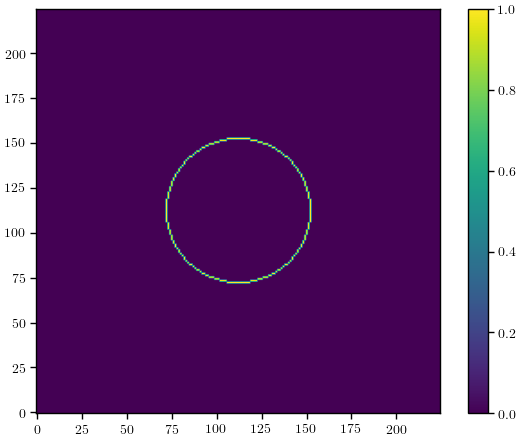

In [8]:
from skimage import draw
model = np.zeros((225, 225))
rr, cc = draw.circle_perimeter(112, 112, radius=40, shape=model.shape)
model[rr, cc] = 1

plt.imshow(model)
plt.colorbar()
plt.show()

In [9]:
detectors = [i + 1 for i in range(18)]
images = []

for band, model in zip(bands, models):
    total_flux_cps = lens.get_total_flux_cps(band)
    interp = InterpolatedImage(Image(model, xmin=0, ymin=0), scale=0.11 / oversample, flux=total_flux_cps * 146)

    interpolated_images = [interp] * 18

    for detector, interp in tqdm(zip(detectors, interpolated_images), total=len(detectors)):
        detector_pos = (2048, 2048)

        # generate PSF
        psf_kernel = psf.get_webbpsf_psf(band, detector, detector_pos, oversample)

        # convolve image with PSF
        convolved = gs.convolve(interp, psf_kernel, num_pix)

        # quantize
        convolved.quantize()

        # get array
        final_array = convolved.array

        # divide through by exposure time to get in units of counts/sec/pixel
        final_array /= 146

        images.append(final_array)
    
np.save(os.path.join(array_dir, 'residuals_across_fov_images.npy'), images)

100%|██████████| 18/18 [05:10<00:00, 17.26s/it]


In [11]:
images = np.load(os.path.join(array_dir, 'residuals_across_fov_images.npy'))

In [ ]:
mean_residual_counts = []

for detector in tqdm(detectors):
    ref_sca = detector

    residuals = []
    for i, image in enumerate(images):
        if i + 1 == ref_sca:
            continue
        else:
            residuals.append(images[ref_sca - 1] - image)

    mean_residual_counts.append(np.mean(np.abs(residuals)))

    v = plot_util.get_v(residuals) 

    residuals.insert(ref_sca - 1, images[ref_sca - 1])

    to_plot = residuals

    show_sca_id = True
    savefig = True
    savepath = os.path.join(figure_dir, 'residuals_across_fov', f'residuals_across_fov_wrt_SCA{str(ref_sca).zfill(2)}.png')
    clabel = None
    title = None

    detector = plt.figure(figsize=(10,6),dpi=300)
    nrows, ncols = 55,91
    grid = detector.add_gridspec(nrows=nrows,ncols=ncols,figure=detector, 
                                    width_ratios=[1]*ncols, height_ratios=[1]*nrows,
                                    hspace=0,wspace=0.1)
    row_begins = np.array([10,3,0,0,3,10])
    row_ends = np.array([x+14 for x in row_begins])
    col_begins = np.arange(0,ncols,14)
    col_ends = np.array([x+14 for x in col_begins])
    add_distance = [15,16,16]

    axs = []
    for row in add_distance:
        for i in range(len(row_begins)):
            ax = detector.add_subplot(grid[row_begins[i]:row_ends[i],col_begins[i]+1:col_ends[i]])
            ax.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
            axs.append(ax)

        row_begins += row
        row_ends += row

    # Argument data_array should be an array of len(N SCAs) containing arrays:
    # data_array = np.array([np.random.rand(14,14)]*len(axs))  # TODO this is fake data
    # data_array = np.array(np.log10(images))  # rgb_images
    data_array = np.array(to_plot)
    # vmin = np.nanmin(data_array.ravel())
    # vmax = np.nanmax(data_array.ravel())

    # sortidx = sca_order.argsort()
    # sca_order = sca_order[sortidx]
    # data_array = data_array[sortidx]
    imsim_sca_order = np.array([9,6,3,12,15,18,8,5,2,11,14,17,7,4,1,10,13,16])-1

    for i, sca in enumerate(imsim_sca_order):
        if sca == ref_sca - 1:
            im = axs[i].imshow(data_array[sca])  # , cmap='plasma', vmin=vmin,vmax=vmax
        else:
            im = axs[i].imshow(data_array[sca], cmap='bwr', vmin=-0.5, vmax=0.5)
            
        if show_sca_id:
            axs[i].annotate(sca+1, xy=(0,2), fontsize=12)

    # cbar_ax = detector.add_subplot(grid[:,-4:-1])
    # cbar = plt.colorbar(im, cax=cbar_ax)
    # if clabel is not None:
    #     cbar.set_label(clabel, labelpad=20, fontsize=18, rotation=270)
    if title is not None:
        plt.suptitle(title, y=0.93, fontsize=18)
    if savefig:
        plt.savefig(savepath, dpi=300, bbox_inches='tight')

    plt.close()

In [ ]:
for i, mean in enumerate(mean_residual_counts):
    print(f"Mean residual counts for SCA{str(i+1).zfill(2)}: {np.abs(mean):.6f}")

In [ ]:
to_plot = [np.ones((14, 14)) * u for u in mean_residual_counts]

vmin = np.min(mean_residual_counts)
vmax = np.max(mean_residual_counts)

In [ ]:
show_sca_id = True
savefig = True
savepath = os.path.join(figure_dir, 'residuals_across_fov', 'abs_error.png')
clabel = None
title = None

detector = plt.figure(figsize=(10,6),dpi=300)
nrows, ncols = 55,91
grid = detector.add_gridspec(nrows=nrows,ncols=ncols,figure=detector, 
                                width_ratios=[1]*ncols, height_ratios=[1]*nrows,
                                hspace=0,wspace=0.1)
row_begins = np.array([10,3,0,0,3,10])
row_ends = np.array([x+14 for x in row_begins])
col_begins = np.arange(0,ncols,14)
col_ends = np.array([x+14 for x in col_begins])
add_distance = [15,16,16]

axs = []
for row in add_distance:
    for i in range(len(row_begins)):
        ax = detector.add_subplot(grid[row_begins[i]:row_ends[i],col_begins[i]+1:col_ends[i]])
        ax.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
        axs.append(ax)

    row_begins += row
    row_ends += row

# Argument data_array should be an array of len(N SCAs) containing arrays:
# data_array = np.array([np.random.rand(14,14)]*len(axs))  # TODO this is fake data
# data_array = np.array(np.log10(images))  # rgb_images
data_array = np.array(to_plot)
# vmin = np.nanmin(data_array.ravel())
# vmax = np.nanmax(data_array.ravel())

# sortidx = sca_order.argsort()
# sca_order = sca_order[sortidx]
# data_array = data_array[sortidx]
imsim_sca_order = np.array([9,6,3,12,15,18,8,5,2,11,14,17,7,4,1,10,13,16])-1

for i, sca in enumerate(imsim_sca_order):
    im = axs[i].imshow(data_array[sca], vmin=vmin, vmax=vmax)  # , cmap='plasma', vmin=vmin,vmax=vmax
        
    if show_sca_id:
        axs[i].annotate(sca+1, xy=(0,2), fontsize=12)

cbar_ax = detector.add_subplot(grid[:,-4:-1])
cbar = plt.colorbar(im, cax=cbar_ax)
# if clabel is not None:
#     cbar.set_label(clabel, labelpad=20, fontsize=18, rotation=270)
if title is not None:
    plt.suptitle(title, y=0.93, fontsize=18)
if savefig:
    plt.savefig(savepath, dpi=300, bbox_inches='tight')

plt.show()